In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt # matplotlib is for drawing graphs
import matplotlib.colors as colors
from sklearn.utils import resample # downsample the dataset
from sklearn.model_selection import train_test_split # split data into training and testing sets
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC # this will make a support vector machine for classificaiton
from sklearn.model_selection import GridSearchCV #this will do cross validation
from sklearn.metrics import confusion_matrix # this creates a confusion matrix
from sklearn.decomposition import PCA # to perform PCA to plot the data
from sklearn.metrics import precision_score, accuracy_score, recall_score
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc

In [21]:
df = pd.read_csv("default of credit card clients.txt",sep='\t',header=1)
df.drop('ID',axis=1,inplace=True)
df.rename(columns={'default payment next month': 'DEFAULT'}, inplace=True)
df_no_missing = df.loc[(df['MARRIAGE']!=0) & (df['EDUCATION']!=0)]
df_no_missing.head()
df_no_default = df_no_missing[df_no_missing['DEFAULT']==0]
df_default = df_no_missing[df_no_missing['DEFAULT']==1]
df_no_default_downsampled = resample(df_no_default,replace=False,n_samples=1000,random_state=42)
df_default_downsampled = resample(df_default,replace=False,n_samples=1000,random_state=42)
df_downsampled = pd.concat([df_no_default_downsampled,df_default_downsampled])
X = df_downsampled.drop(['DEFAULT'],axis=1).copy()
y = df_downsampled['DEFAULT'].copy()
X_encoded = pd.get_dummies(X,columns=['SEX','EDUCATION','MARRIAGE','PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6']).astype(int)
X_train,X_test,y_train,y_test = train_test_split(X_encoded,y,random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)
print("pre-proccessing");

pre-proccessing


Number of columns: 81


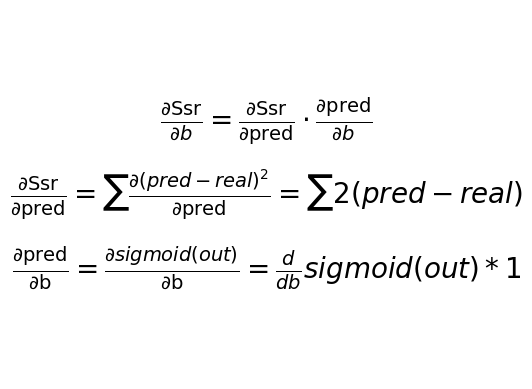

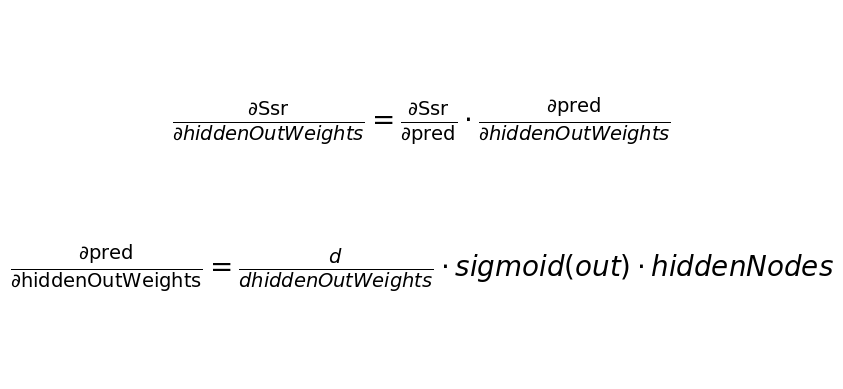

In [23]:
print(f"Number of columns: {X_train_scaled.shape[1]}")
input_nodes_num = X_train_scaled.shape[1]
hidden_nodes_num = 8
output_nodes_num = 1
np.random.seed(42)


equation1 = r'$\frac{\partial \text{Ssr}}{\partial b} = \frac{\partial \text{Ssr}}{\partial \text{pred}} \cdot \frac{\partial \text{pred}}{\partial b}$'
equation2 = r'$\frac{\partial \text{Ssr}}{\partial \text{pred}} = \sum\frac{\partial (pred - real)^{2}}{\partial \text{pred}} = \sum2(pred - real)$'
equation3 = r'$\frac{\partial \text{pred}}{\partial \text{b}} = \frac{\partial sigmoid(out)}{\partial \text{b}} = \frac{d}{db}sigmoid(out)*1$'    
plotEquations(equation1,equation2,equation3)
equation1 = r'$\frac{\partial \text{Ssr}}{\partial hiddenOutWeights} = \frac{\partial \text{Ssr}}{\partial \text{pred}} \cdot \frac{\partial \text{pred}}{\partial hiddenOutWeights}$' 
equation2 = ''
equation3 = r'$\frac{\partial \text{pred}}{\partial \text{hiddenOutWeights}} =  \frac{d}{dhiddenOutWeights} \cdot sigmoid(out)\cdot hiddenNodes$'    
plotEquations(equation1,equation2,equation3)


In [44]:
learning_rate = 0.001
#hidden-input layer wieghts and biases
input_hidden_weights = np.random.rand(input_nodes_num,hidden_nodes_num)
input_hidden_baises = np.zeros(hidden_nodes_num)

#hidden-output layer wieghts and biases
hidden_out_weights = np.random.rand(hidden_nodes_num,output_nodes_num)
hidden_out_baises = 0
# print(f"hidden_out_baises : {hidden_out_baises}" )
# print(f"hidden_out_weights : {hidden_out_weights}" )
# print(f"input_hidden_weights : {input_hidden_weights}" )
# print(f"input_hidden_baises : {input_hidden_baises}" )X_train_scaled[i]
for epoch in range(100):
    i =0
    predicated_values = []
    hidden_layer =[]
    outputs_values =[]
    for i in range(0,len(X_train_scaled)):
        input_nodes = X_train_scaled[i]
        pred,hidden_nodes,output_node = forward(input_nodes,input_hidden_weights,hidden_out_weights,input_hidden_baises,hidden_out_baises)
        real = y_train.iloc[i]
        outputs_values.append(output_node)
        predicated_values.append(pred)
        hidden_layer.append(hidden_nodes)
    # mydf = pd.DataFrame({
    #     'outputs': outputs_values,
    #     'real': y_train,
    #     'predicated': predicated_values
    # })
    # #print(mydf)

    
    outputs_values = np.array(outputs_values).flatten()
    predicated_values = np.array(predicated_values).flatten()
    hidden_layer = np.array(hidden_layer)
    observed_values =  y_train.to_numpy()

    ssr = np.sum((observed_values-predicated_values)**2)
    loss = binary_cross_entropy(y_train.to_numpy(), outputs_values)
    #print("Initial Loss:", loss)
    
     # Compute gradients for output layer
    dSSR_dpred = predicated_values - observed_values  # Gradient of loss with respect to predictions
    sigmoid_derivs = sigmoid_derivative(outputs_values)  # Derivative of sigmoid output
    
    d_output_weights = np.dot(hidden_layer.T, (dSSR_dpred * sigmoid_derivs).reshape(-1, 1))
    d_output_biases = np.sum(dSSR_dpred * sigmoid_derivs, axis=0)
    
    # Compute gradients for hidden layer
    d_hidden_error = (dSSR_dpred * sigmoid_derivs).reshape(-1, 1) @ hidden_out_weights.T * hidden_layer>0
    
    d_hidden_weights = np.dot(X_train_scaled.T, d_hidden_error)
    d_hidden_biases = np.sum(d_hidden_error, axis=0)
    
    # Update weights and biases
    input_hidden_weights -= learning_rate * d_hidden_weights
    input_hidden_baises -= learning_rate * d_hidden_biases
    
    hidden_out_weights -= learning_rate * d_output_weights
    hidden_out_baises -= learning_rate * d_output_biases

print(f"hidden_out_baises : {hidden_out_baises}" )
print(f"hidden_out_weights : {hidden_out_weights}" )
print(f"input_hidden_weights : {input_hidden_weights}" )
print(f"input_hidden_baises : {input_hidden_baises}" )

hidden_out_baises : -0.08862407990212284
hidden_out_weights : [[0.75328175]
 [0.5142237 ]
 [0.82466709]
 [0.83406258]
 [0.87227575]
 [0.47573841]
 [0.45739802]
 [0.81974071]]
input_hidden_weights : [[-0.14657889  0.03894908 -0.33020932  0.00150222 -0.0689834  -0.26633586
   0.00372555  0.06024691]
 [-0.03362343  0.08709527  0.29597697  0.31355365  0.370989    0.36040346
   0.37324223  0.43436584]
 [-0.10526896 -0.22955246  0.40484802  0.21974207 -0.22574329  0.09450595
   0.49776367  0.13691761]
 [-0.01264618  0.0775769  -0.22103197 -0.10870224  0.05946879 -0.28021028
   0.24721252 -0.01610174]
 [ 0.29274355  0.41358696 -0.28607916  0.0688567   0.03240715  0.41598449
  -0.21992661  0.21708379]
 [ 0.05206543 -0.20982264 -0.30921265  0.14289333  0.31903617 -0.01366
   0.17397002 -0.11165578]
 [ 0.19490976 -0.30190299  0.45910337 -0.18588879 -0.10555587 -0.30495882
  -0.32707914  0.02383584]
 [-0.28252224  0.28005524 -0.43087144 -0.10491794 -0.11714221 -0.31166901
  -0.27430953 -0.0804355

In [22]:
def forward(input_nodes1,input_hidden_weights1,hidden_out_weights1,input_hidden_baises1,hidden_out_baises1):
    #initialize hidden nodes
    hidden_nodes1 = np.dot(input_nodes1,input_hidden_weights1)
    hidden_nodes1 = np.add(hidden_nodes1,input_hidden_baises1)
    hidden_nodes1 = relu(hidden_nodes1)
    #initialize out node
    output_node1 = np.dot(hidden_nodes1,hidden_out_weights1)
    output_node1 = np.add(output_node1,hidden_out_baises1)
    predictions1 = sigmoid(output_node1)
    return predictions1,hidden_nodes1,output_node1
def plotEquations(q1,q2,q3):
    import matplotlib.pyplot as plt

    fig, ax = plt.subplots()

    ax.axis('off')
    
    ax.text(0.5, 0.7, q1, fontsize=20, ha='center', va='center')
    
    ax.text(0.5, 0.5, q2, fontsize=20, ha='center', va='center')
    
    ax.text(0.5, 0.3, q3, fontsize=20, ha='center', va='center')
    
    plt.savefig('equations.png', bbox_inches='tight', pad_inches=0.1, dpi=300)
    plt.show()
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
def relu(x):
    return np.maximum(0, x) 
def sigmoid_derivative(x):
    sigmoid_x = sigmoid(x)
    return sigmoid_x * (1 - sigmoid_x)
def binary_cross_entropy(y_true, y_pred):
    epsilon = 1e-15
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))    

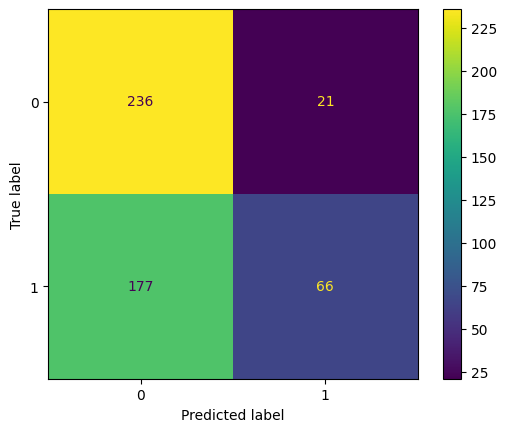

Precision: 0.7586
Accuracy: 0.6040
Sensitivity (Recall): 0.2716


In [45]:
predictions = []
for i in range(0,len(X_test_scaled)):
    input_nodes = X_test_scaled[i]
    pred,_,_ = forward(input_nodes,input_hidden_weights,hidden_out_weights,input_hidden_baises,hidden_out_baises)
    predictions.append(pred)
binary_predictions = (np.array(predictions)>= 0.5).astype(int)

cm = confusion_matrix(y_test, binary_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()
    # Calculate precision, accuracy, and sensitivity
precision = precision_score(y_test, binary_predictions)
accuracy = accuracy_score(y_test, binary_predictions)
sensitivity = recall_score(y_test, binary_predictions)

print(f'Precision: {precision:.4f}')
print(f'Accuracy: {accuracy:.4f}')
print(f'Sensitivity (Recall): {sensitivity:.4f}')    

In [51]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam,RMSprop,SGD
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [58]:
model = Sequential()

# Input layer (automatically inferred)
input_shape = X_train_scaled.shape[1]
model.add(Input(shape=(input_shape,)))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# Compile the model
model.compile(optimizer=SGD(learning_rate=0.01), loss='binary_crossentropy', metrics=['precision','accuracy'])

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_split=0.2,verbose=0)

# Evaluate the model
loss, accuracy,precision = model.evaluate(X_test_scaled, y_test)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')
print(f'Test precision: {precision}')

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6621 - loss: 0.6431 - precision: 0.6838 
Test Loss: 0.6235223412513733
Test Accuracy: 0.677570104598999
Test precision: 0.6660000085830688


In [43]:
weights_and_biases = model.get_weights()

# Separate weights and biases for better understanding
weights = weights_and_biases[::2]  # Even indices are weights
biases = weights_and_biases[1::2]  # Odd indices are biases

# Print weights and biases for each layer
for i, (w, b) in enumerate(zip(weights, biases)):
    print(f"Layer {i+1} weights shape: {w.shape}")
    print(f"Layer {i+1} weights: {w}")
    print(f"Layer {i+1} biases shape: {b.shape}")
    print(f"Layer {i+1} biases: {b}")
    

Layer 1 weights shape: (81, 8)
Layer 1 weights: [[-1.02840149e+00  5.20988822e-01  8.69667828e-01  1.21387684e+00
  -1.32495248e+00  1.10797562e-01 -2.14383066e-01  1.15031147e+00]
 [-4.14078385e-01 -9.41365302e-01  7.57680178e-01  3.90196502e-01
  -6.94406807e-01  3.39370989e-03  5.34422398e-01 -9.92399096e-01]
 [-6.23400033e-01  3.57314736e-01  2.05946714e-01  9.07119751e-01
   8.18825722e-01 -4.69633192e-01  7.50499249e-01 -5.69172919e-01]
 [-1.66337097e+00  4.21823055e-01  9.05542254e-01  6.50808871e-01
   6.15638912e-01 -6.46312237e-02  4.99431252e-01  1.28650129e-01]
 [-1.37548018e+00  5.34393191e-01  3.14346075e-01 -1.00309342e-01
   1.66122213e-01 -2.80319005e-01  8.64372849e-01  5.30391395e-01]
 [-7.13060200e-01  1.26199901e+00 -9.49227750e-01 -1.38075560e-01
   1.13420419e-01  1.10450315e+00 -1.58827037e-01 -1.04625273e+00]
 [-5.31853437e-01 -1.34633398e+00  9.48136002e-02 -7.15345323e-01
   2.57050157e-01 -1.87036976e-01  1.01537323e+00  6.56747639e-01]
 [-5.68102360e-01 -1.